In [ ]:
# testing pretrained model
# %pip install torch torchvision matplotlib
# %pip install lime
# %pip install opencv-python

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torchvision.transforms.functional as F
import cv2
import random
import os
from PIL import Image

In [2]:
class EdgeEnhancementTransform:
    def __call__(self, img):
        img = np.array(F.to_grayscale(img))  # Convert to grayscale
        img = cv2.GaussianBlur(img, (3, 3), 0)  # Reduce noise
        edges = cv2.Laplacian(img, cv2.CV_64F)  # Edge detection
        edges = np.clip((edges - edges.min()) / (edges.max() - edges.min()) * 255, 0, 255).astype(np.uint8)
        edges = Image.fromarray(edges).convert('RGB')  # Convert back to PIL Image
        return edges

# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([EdgeEnhancementTransform()], p=0.5),  # Apply edge emphasis randomly
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjusted normalization
])

# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [3]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

Number of training samples: 3410
Number of testing samples: 853


In [4]:
# data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# loading ResNet50 (pretrained model for transfer learning)
model = models.resnet50(weights="DEFAULT")
for param in model.parameters():
    param.requires_grad = False

num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [6]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [7]:
# Training loop
epochs = 50
print("Training started...")

loss_trace = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    loss_trace.append(running_loss/len(train_loader))

print("Training complete.")

Training started...
Epoch 1/50, Loss: 1.5150
Epoch 2/50, Loss: 1.0899
Epoch 3/50, Loss: 0.9439
Epoch 4/50, Loss: 0.8575
Epoch 5/50, Loss: 0.8141
Epoch 6/50, Loss: 0.7791
Epoch 7/50, Loss: 0.7501
Epoch 8/50, Loss: 0.7002
Epoch 9/50, Loss: 0.6955
Epoch 10/50, Loss: 0.6657
Epoch 11/50, Loss: 0.6589
Epoch 12/50, Loss: 0.6432
Epoch 13/50, Loss: 0.6354
Epoch 14/50, Loss: 0.6200
Epoch 15/50, Loss: 0.5990
Epoch 16/50, Loss: 0.5939
Epoch 17/50, Loss: 0.5807
Epoch 18/50, Loss: 0.5755
Epoch 19/50, Loss: 0.5678
Epoch 20/50, Loss: 0.5470
Epoch 21/50, Loss: 0.5435
Epoch 22/50, Loss: 0.5559
Epoch 23/50, Loss: 0.5430
Epoch 24/50, Loss: 0.5243
Epoch 25/50, Loss: 0.5181
Epoch 26/50, Loss: 0.5098
Epoch 27/50, Loss: 0.5263
Epoch 28/50, Loss: 0.5061
Epoch 29/50, Loss: 0.5021
Epoch 30/50, Loss: 0.4985
Epoch 31/50, Loss: 0.5209
Epoch 32/50, Loss: 0.4949
Epoch 33/50, Loss: 0.4822
Epoch 34/50, Loss: 0.4845
Epoch 35/50, Loss: 0.4913
Epoch 36/50, Loss: 0.4865
Epoch 37/50, Loss: 0.4788
Epoch 38/50, Loss: 0.4940
E

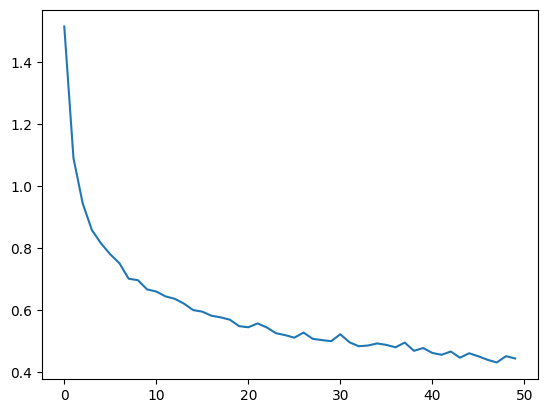

In [8]:
plt.plot(loss_trace)

In [11]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score (Macro for Multi-class)
fscore = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'resnet50_model2-nobg.pth')
print("Model saved.")

Testing Accuracy: 77.96%
F1-Score: 0.7664
Model saved.
